In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

In [2]:
import numpy as np
from random import randrange
from scipy.optimize import check_grad
from scipy.sparse import csr_matrix
from keras.utils.np_utils import to_categorical
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
"""
у меня jupyter notebook почему-то не видел этот файлик, хотя они были в одной папке, поэтому я 
вставила функции просто в блок, по-другому не получалось
"""

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
  # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
              print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
    
        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval
    
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]
            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig
      
            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
        
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in xrange(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + 
                                                           abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % 
               (grad_numerical, grad_analytic, rel_error))

In [4]:
def rel_error(x, y):
      return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16

https://www.pyimagesearch.com/2016/10/10/gradient-descent-with-python/

https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/model_solver.html

In [13]:
def softmax_loss(x, y):
    
    probs = np.exp(x - np.max (x, axis=1, keepdims=True))
    probs /= np.sum (probs, axis=1, keepdims=True)
    
    N = x.shape[0]
    
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N 
    dx = probs.copy()    
    dx[np.arange(N), y] -= 1    
    dx /= N
    
    return loss, dx

In [26]:
y = np.random.randint(0, 3, 10)
dx = lambda x: softmax_loss(x.reshape((10, 3)), y)[1].reshape(-1)
loss = lambda x: softmax_loss(x.reshape((10, 3)), y)[0]

In [27]:
print('loss is a scalar\n', loss(np.random.random((10, 3))))
print('gradient is a matrix with shape 10x3\n', dx(np.random.random((10, 3))))
print('difference should be ~10e-8', check_grad(loss, dx, np.random.random((10, 3)).reshape(-1)))

loss is a scalar
 1.02024765831
gradient is a matrix with shape 10x3
 [-0.07311599  0.02776     0.045356    0.02083207  0.04395216 -0.06478424
 -0.07878944  0.04836753  0.03042191  0.03209705 -0.07874838  0.04665133
 -0.06562582  0.04061855  0.02500726  0.03531997  0.03547021 -0.07079018
 -0.05161597  0.02558227  0.0260337  -0.07136769  0.03489463  0.03647307
  0.03562948  0.0367558  -0.07238527  0.03043723 -0.06206345  0.03162621]
difference should be ~10e-8 4.53771950311e-08


https://mlxai.github.io/2017/01/10/a-modular-approach-to-implementing-fully-connected-neural-networks.html

In [15]:
def affine_forward(x, w, b):
    out = None
        
    pass

    # out = x*W + b
    out = x.reshape(x.shape[0], w.shape[0]).dot(w) + b
    cache = (x, w, b)
    
    return out, cache

In [16]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print ('Testing affine_forward function:')
print ('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76985004799e-10


In [17]:
def affine_backward(dout, cache):
    
    x, w, b = cache
    dx, dw, db = None, None, None
    
    pass
    
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], w.shape[0]).T.dot(dout)
    db = np.sum(dout, axis=0)
    
    return dx, dw, db

In [18]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print ('Testing affine_backward function:')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.99765929149e-10
dw error:  1.34027358451e-10
db error:  1.31765828013e-11


https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/relu_layer.html

In [19]:
def relu_forward(x):
    
    out = None
    pass
    relu = lambda x: x * (x > 0).astype(float)
    out = relu(x)
    cache = x
    return out, cache

In [20]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print ('Testing relu_forward function:')
print ('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


In [21]:
def relu_backward(dout, cache):

    dx, x = None, cache
    pass
    
    dx = dout * (x >= 0)

    return dx

In [22]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print ('Testing relu_backward function:')
print ('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27561945151e-12


In [23]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


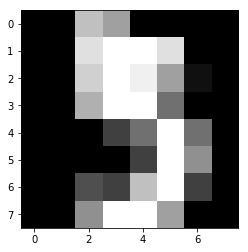

In [24]:
pylab.imshow(X[5].reshape((8, 8)), cmap='gray')

https://www.kaggle.com/tamamo/neural-network-using-sgd/edit?unified=1

Populating the interactive namespace from numpy and matplotlib
epoch 0: 	 tr_loss inf 	 te_loss inf 	 te_acc 0.10555555555555556


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


epoch 1000: 	 tr_loss 6.29 	 te_loss 5.77 	 te_acc 0.6814814814814815
epoch 2000: 	 tr_loss 2.96 	 te_loss 2.56 	 te_acc 0.8092592592592592
epoch 3000: 	 tr_loss 0.80 	 te_loss 1.74 	 te_acc 0.8629629629629629
epoch 4000: 	 tr_loss 0.82 	 te_loss 1.38 	 te_acc 0.8777777777777778
epoch 5000: 	 tr_loss 0.61 	 te_loss 1.21 	 te_acc 0.8962962962962963
epoch 6000: 	 tr_loss 1.08 	 te_loss 1.16 	 te_acc 0.9
epoch 7000: 	 tr_loss 0.51 	 te_loss 1.00 	 te_acc 0.9037037037037037
epoch 8000: 	 tr_loss 0.13 	 te_loss 0.89 	 te_acc 0.9111111111111111
epoch 9000: 	 tr_loss 0.42 	 te_loss 0.78 	 te_acc 0.9314814814814815
epoch 10000: 	 tr_loss 0.39 	 te_loss 0.84 	 te_acc 0.924074074074074
epoch 11000: 	 tr_loss 0.73 	 te_loss 0.76 	 te_acc 0.9333333333333333
epoch 12000: 	 tr_loss 0.19 	 te_loss 0.74 	 te_acc 0.9314814814814815
epoch 13000: 	 tr_loss 0.29 	 te_loss 0.73 	 te_acc 0.9277777777777778
epoch 14000: 	 tr_loss 0.32 	 te_loss 0.83 	 te_acc 0.9277777777777778
epoch 15000: 	 tr_loss 0.04 	 t

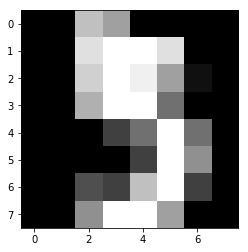

In [25]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%pylab inline

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

pylab.imshow(X[5].reshape((8, 8)), cmap='gray')


W1, b1 = np.random.random((64, 100)), np.random.random(100)
W2, b2 = np.random.random((100, 10)), np.random.random(10)

lr = 1e-4

for i in range(50000):
    batch_index = np.random.randint(0, X_train.shape[0], 100)
    batch_X, batch_y = X_train[batch_index], y_train[batch_index]
    
    out1, cache1 = affine_forward(batch_X, W1, b1) # Dense Layer
    out2, cache2 = relu_forward(out1)              # ReLu Layer
    out3, cache3 = affine_forward(out2,    W2, b2) # Dense Layer 
    tr_loss, dx = softmax_loss(out3, batch_y)      # Loss Layer 
    
    dx, dW2, db2 = affine_backward(dx, cache3)
    dx = relu_backward(dx, cache2)
    dx, dW1, db1 = affine_backward(dx, cache1)

    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1    
   
    out1, cache1 = affine_forward(X_test, W1, b1) # Dense Layer
    out2, cache2 = relu_forward(out1)              # ReLu Layer
    out3, cache3 = affine_forward(out2,    W2, b2) # Dense Layer 
    te_loss, dx = softmax_loss(out3, y_test)         # Loss Layer 

    probs = np.exp(out3 - np.max(out3, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    y_pred = np.argmax(probs, axis=1)
    
    if i % 1000 == 0:
        print('epoch {}: \t tr_loss {:.2f} \t te_loss {:.2f} \t te_acc {}'.
              format(i, tr_loss , te_loss, accuracy_score(y_pred, y_test)))